In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import random_split, ConcatDataset

# DOWNLOADING DATA AND PREPROCESSING

In [ ]:
train_size = 48000
val_size =  5000
test_size = 12000
batch_size=512
random_seed = 42
torch.cuda.is_available()

True

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
full_DS = ConcatDataset([dataset,testset])


torch.manual_seed(random_seed);
train_ds, testset = random_split(full_DS, [train_size, test_size])
train_ds, val_ds = random_split(train_ds, [train_size-val_size, val_size])



train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
len(train_ds), len(val_ds), len(testset)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_ds), len(val_ds), len(testset)

60000

# MODEL DEFINATIONS

In [ ]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class part1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3, 128, kernel_size=6),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            

            nn.Flatten(), 
            nn.Linear(128*14*14, 10))
        

    def forward(self, xb):
        return self.network(xb)
class part2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3, 128, kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            

            nn.Flatten(), 
            nn.Linear(128*14*14, 10))
        

    def forward(self, xb):
        return self.network(xb)
class part3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3, 128, kernel_size=6),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            

            nn.Flatten(), 
            nn.Linear(128*14*14, 60),
            nn.ReLU(),
            nn.Linear(60,10))
        

    def forward(self, xb):
        return self.network(xb)
class part4(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3, 128, kernel_size=6),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=6),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            

            nn.Flatten(), 
            nn.Linear(512*4*4, 10))
        

    def forward(self, xb):
        return self.network(xb)
class part5(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.ZeroPad2d(1),
            nn.Conv2d(3, 128, kernel_size=6),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=6),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(512, 1024, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(1024*2*2, 10))
        

    def forward(self, xb):
        return self.network(xb)

# HELPER FUNCTIONS

## DATA LOADER TO CUDA

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## HELPER FUNCTION FOR TRAINING AND EVALUATING

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(question_no,epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    val_accuracy = 0
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if (val_accuracy < history[-1]["val_acc"]):
            torch.save(model.state_dict(), question_no)
            print("saving model for", question_no)
            val_accuracy = history[-1]["val_acc"]
    return history
def test_accuracy(model, test_loader):
    result = evaluate(model, test_loader)    
    return result["val_acc"]

# PARAMETERS AND MOVING TO CUDA


In [ ]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001


In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


#PART 1

In [ ]:
model1 = to_device(part1(), device);
history1 = fit("part1",num_epochs, lr, model1, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 2.0787, val_loss: 1.5533, val_acc: 0.5305
saving model for part1
Epoch [1], train_loss: 1.3041, val_loss: 1.4664, val_acc: 0.5712
saving model for part1
Epoch [2], train_loss: 1.1253, val_loss: 1.4311, val_acc: 0.5875
saving model for part1
Epoch [3], train_loss: 0.9803, val_loss: 1.3895, val_acc: 0.6037
saving model for part1
Epoch [4], train_loss: 0.8698, val_loss: 1.5447, val_acc: 0.5959
Epoch [5], train_loss: 0.7791, val_loss: 1.4578, val_acc: 0.6036
Epoch [6], train_loss: 0.6656, val_loss: 1.5067, val_acc: 0.6077
saving model for part1
Epoch [7], train_loss: 0.5968, val_loss: 1.5190, val_acc: 0.6020
Epoch [8], train_loss: 0.5316, val_loss: 1.5397, val_acc: 0.6066
Epoch [9], train_loss: 0.4776, val_loss: 1.5474, val_acc: 0.6182
saving model for part1
Epoch [10], train_loss: 0.4079, val_loss: 1.6357, val_acc: 0.6167
Epoch [11], train_loss: 0.3802, val_loss: 1.7322, val_acc: 0.6003
Epoch [12], train_loss: 0.3380, val_loss: 1.6813, val_acc: 0.6231
saving model f

In [ ]:
model1.load_state_dict(torch.load("part1"))
print("accuracy for part 1 = ", test_accuracy(model1,test_dl)*100,"%")

accuracy for part 1 =  62.90000081062317 %


#PART 2

In [ ]:
model2 = to_device(part2(), device);
history2 = fit("part2",num_epochs, lr, model2, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.5973, val_loss: 1.3173, val_acc: 0.5442
saving model for part2
Epoch [1], train_loss: 1.1977, val_loss: 1.1965, val_acc: 0.5873
saving model for part2
Epoch [2], train_loss: 1.0673, val_loss: 1.1125, val_acc: 0.6105
saving model for part2
Epoch [3], train_loss: 0.9815, val_loss: 1.0615, val_acc: 0.6315
saving model for part2
Epoch [4], train_loss: 0.9292, val_loss: 1.0246, val_acc: 0.6452
saving model for part2
Epoch [5], train_loss: 0.8770, val_loss: 1.0607, val_acc: 0.6308
Epoch [6], train_loss: 0.8460, val_loss: 1.0013, val_acc: 0.6570
saving model for part2
Epoch [7], train_loss: 0.7935, val_loss: 0.9966, val_acc: 0.6559
Epoch [8], train_loss: 0.7733, val_loss: 1.0069, val_acc: 0.6599
saving model for part2
Epoch [9], train_loss: 0.7349, val_loss: 0.9702, val_acc: 0.6711
saving model for part2
Epoch [10], train_loss: 0.7241, val_loss: 0.9998, val_acc: 0.6636
Epoch [11], train_loss: 0.6839, val_loss: 0.9969, val_acc: 0.6638
Epoch [12], train_loss: 0.6489, va

In [ ]:
model2.load_state_dict(torch.load("part2"))
print("accuracy for part 2 = ", test_accuracy(model2,test_dl)*100,"%")

accuracy for part 2 =  67.36666560173035 %


#PART 3

In [ ]:
model3 = to_device(part3(), device);
history3 = fit("part3",num_epochs, lr, model3, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.8336, val_loss: 1.4594, val_acc: 0.4697
saving model for part3
Epoch [1], train_loss: 1.3234, val_loss: 1.2476, val_acc: 0.5462
saving model for part3
Epoch [2], train_loss: 1.1342, val_loss: 1.1560, val_acc: 0.5933
saving model for part3
Epoch [3], train_loss: 1.0237, val_loss: 1.1133, val_acc: 0.6090
saving model for part3
Epoch [4], train_loss: 0.9496, val_loss: 1.0794, val_acc: 0.6196
saving model for part3
Epoch [5], train_loss: 0.8930, val_loss: 1.0957, val_acc: 0.6246
saving model for part3
Epoch [6], train_loss: 0.8351, val_loss: 1.0719, val_acc: 0.6334
saving model for part3
Epoch [7], train_loss: 0.7761, val_loss: 1.0948, val_acc: 0.6321
Epoch [8], train_loss: 0.7262, val_loss: 1.0828, val_acc: 0.6371
saving model for part3
Epoch [9], train_loss: 0.6799, val_loss: 1.0962, val_acc: 0.6355
Epoch [10], train_loss: 0.6360, val_loss: 1.1531, val_acc: 0.6271
Epoch [11], train_loss: 0.5839, val_loss: 1.1415, val_acc: 0.6379
saving model for part3
Epoch [12],

In [ ]:
model3.load_state_dict(torch.load("part3"))
print("accuracy for part 3 = ", test_accuracy(model3,test_dl)*100,"%")

accuracy for part 3 =  64.77500200271606 %


#PART 4

In [ ]:
model4 = to_device(part4(), device);
history4 = fit("part4",num_epochs, lr, model4, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.6267, val_loss: 1.2564, val_acc: 0.5668
saving model for part4
Epoch [1], train_loss: 1.0251, val_loss: 1.1502, val_acc: 0.6139
saving model for part4
Epoch [2], train_loss: 0.7989, val_loss: 0.9627, val_acc: 0.6718
saving model for part4
Epoch [3], train_loss: 0.6138, val_loss: 1.0213, val_acc: 0.6729
saving model for part4
Epoch [4], train_loss: 0.4534, val_loss: 1.0604, val_acc: 0.6760
saving model for part4
Epoch [5], train_loss: 0.3159, val_loss: 1.0869, val_acc: 0.6896
saving model for part4
Epoch [6], train_loss: 0.2025, val_loss: 1.1289, val_acc: 0.7029
saving model for part4
Epoch [7], train_loss: 0.1041, val_loss: 1.1275, val_acc: 0.7168
saving model for part4
Epoch [8], train_loss: 0.0476, val_loss: 1.1267, val_acc: 0.7199
saving model for part4
Epoch [9], train_loss: 0.0191, val_loss: 1.1346, val_acc: 0.7279
saving model for part4
Epoch [10], train_loss: 0.0073, val_loss: 1.1659, val_acc: 0.7321
saving model for part4
Epoch [11], train_loss: 0.0037,

In [ ]:
model4.load_state_dict(torch.load("part4"))
print("accuracy for part 4 = ", test_accuracy(model4,test_dl)*100,"%")

accuracy for part 4 =  74.05833601951599 %


#PART 5

In [ ]:
model5 = to_device(part5(), device);
history5 = fit("part5",num_epochs, lr, model5, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.4987, val_loss: 1.2197, val_acc: 0.5758
saving model for part5
Epoch [1], train_loss: 0.9667, val_loss: 1.0242, val_acc: 0.6437
saving model for part5
Epoch [2], train_loss: 0.7365, val_loss: 0.9517, val_acc: 0.6819
saving model for part5
Epoch [3], train_loss: 0.5418, val_loss: 0.9315, val_acc: 0.6846
saving model for part5
Epoch [4], train_loss: 0.3872, val_loss: 0.9877, val_acc: 0.6955
saving model for part5
Epoch [5], train_loss: 0.2437, val_loss: 0.9373, val_acc: 0.7148
saving model for part5
Epoch [6], train_loss: 0.1308, val_loss: 0.9902, val_acc: 0.7165
saving model for part5
Epoch [7], train_loss: 0.0640, val_loss: 1.0186, val_acc: 0.7240
saving model for part5
Epoch [8], train_loss: 0.0245, val_loss: 1.0205, val_acc: 0.7328
saving model for part5
Epoch [9], train_loss: 0.0070, val_loss: 1.0002, val_acc: 0.7523
saving model for part5
Epoch [10], train_loss: 0.0024, val_loss: 1.0176, val_acc: 0.7506
Epoch [11], train_loss: 0.0015, val_loss: 1.0260, val_

In [ ]:
model5.load_state_dict(torch.load("part5"))
print("accuracy for part 5 = ", test_accuracy(model5,test_dl)*100,"%")

accuracy for part 4 =  76.43333077430725 %


# BEST MODEL GRAPHS

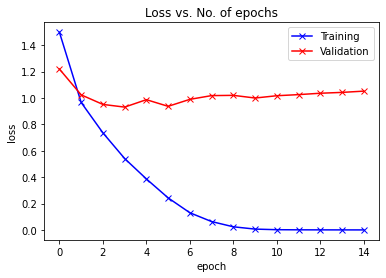

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history5)

In [ ]:
model5

part5(
  (network): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(3, 128, kernel_size=(6, 6), stride=(1, 1))
    (2): ReLU()
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 512, kernel_size=(6, 6), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=4096, out_features=10, bias=True)
  )